In [47]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from IPython.display import Image

# Basic Setup

Let $X$ be our input data and $Y$ be our target in a supervised learning problem and condiser $f(x ;  \theta )$, a class of models we are choosing to solve this problem. 

For instance we may choose $f$ to be a logistic regression model- the class is the family of models we get for different values of $\theta$.

We also need some error function $E(y_1, y_2)$ which we think of as $E(y, f(x))$ to measure how our model is performing.
We then sum up the error for each individaul case to get our total error $$E(Y,f(X, \theta)) = \sum_{x \in X} E(y, f(x, \theta)) $$


Thie error function would typically be mean squared error in a regression scenario, or log loss in a classification scenario. I'll write all this in terms of a generic error function and generic models as the idea of regularization is not model specific, you can basically apply it to any model.


So now we train our model- we use some learning algorithm that finds $\theta_1, \theta_2 \dots $ with the goal being we learn the best $\theta$, so at some iteration $n$ in the future we have for every $\theta$ we have $$E(  Y , f(X;\theta)) \geq E(Y, f(X;\theta_n))$$

or we have found some $\theta_n$ that is the best possible set of weights for the problem- that is it is a global minimum over all possible values of $\theta$. 

This may or may not be possible depending on the choice of the learning algorithm and our error function $E$- but even if this best case scenario isn't achieved we can often achieve something that's still decent. For instance the error drops below some threshold, or we find a local minimum of the function.

# Regularization 

So far we have said nothing interesting, simply described the high level overview. Anyone who has worked with good models an small datasets will know a very common problem is overfitting, where we end up modelling the noise in the dataset as well as the signal. 

Regularization is a way of limiting our large class of models above to a smaller class of simpler models so hopefully this doesn't occur.

There are loads of ways you could do this of course, but regularization chooses simpler models based on the size of the coefficients- which we will see more formally.

A quick note- we will discuss here $L_1$ and $L_2$ regularization, however these are not the only names for these things. You may see LASSO referring to $L_1$ regularization and Ridge referring to $L_2$ especially in statistical journals (or the [Stanford Statistical Learning](https://lagunita.stanford.edu/courses/HumanitiesSciences/StatLearning/Winter2016/about) course). Note also this regularization is performed by default in some of the models we use, for instance XGBoost by default uses $L_2$ as does the Sklearn log reg.

## The $p$ norm 

First we need a quick diversion to some analysis. I won't be too formal on the underlying set up but given some $n$ dimensional (real valued) vector $$x = \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\x_n \end{pmatrix}$$

we define a norm for $p>1$ $$\Vert{x}\Vert_p = \left( \sum_{i=1}^n \vert x_i \vert ^ p \right) ^{1/p}$$

You can check this is actually a norm if you're feeling mathematically inclined (note triangle inequlity is not trivial), however there's no need as we generally only work with two of these norms where $p=1$ and $p=2$, which we call the $L_1$ and $L_2$ norms respectively (if you care about why we use $L$ it's because  of the [$L_p$ space](https://en.wikipedia.org/wiki/Lp_space) but this will likely add nothing to your life).

Let's have a look at these in some more detail- we'll start with the easy one, $L_2$ $$\Vert{x}\Vert_2 = \left( \sum_{i=1}^n \vert x_i \vert ^ 2 \right) ^{1/2} = \sqrt{x_1^2 + x_2^2 + \dots +x_n^2}$$

Hopefully this should look very familiar- it's the standard Euclidean norm, or Pythagoras' Theorem in the case $n=2$, the standard way we all measure distance.

The other norm is a bit more subtle even though it has a simpler formula $$\Vert{x}\Vert_1 =  \sum_{i=1}^n \vert x_i \vert  = \vert x_1 \vert + \vert x_2 \vert  + \dots + \vert x_n \vert $$

What this is saying is we measure distance by just taking sum of how far we are away in each co-ordinate independently. This norm is also called the [taxicab norm](https://en.wikipedia.org/wiki/Taxicab_geometry).

The rough intuition of $p$ norms is smoothness- the higher $p$ the smoother the norm is. A picture will show this a bit more clearly. 


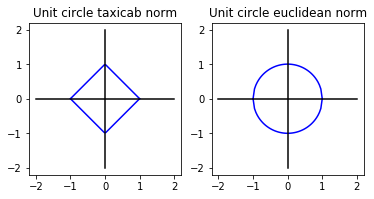

In [48]:
x_1 = np.linspace(-1,1)
f_1 = lambda x: 1 - x if x >= 0 else 1 + x
f_2 = lambda x: x - 1 if x >= 0 else - x - 1
g_1 = lambda x: sqrt(1-x**2)
g_2 = lambda x: -sqrt(1-x**2)
fig, axs = plt.subplots(1, 2)
axs[0].plot(x_1, np.vectorize(f_1)(x_1), color = 'blue')
axs[0].plot(x_1, np.vectorize(f_2)(x_1), color = 'blue')
axs[0].plot(2*x_1, 0 * x_1, 'black')
axs[0].plot(0*x_1, 2 * x_1, 'black')
axs[0].set_aspect('equal')
axs[0].set_title('Unit circle taxicab norm')
axs[1].plot(x_1, np.vectorize(g_1)(x_1), color = 'blue')
axs[1].plot(x_1, np.vectorize(g_2)(x_1), color = 'blue')
axs[1].plot(2*x_1, 0 * x_1, 'black')
axs[1].plot(0*x_1, 2 * x_1, 'black')
axs[1].set_aspect('equal')
axs[1].set_title('Unit circle euclidean norm')
plt.show()

So above I have plotted two unit circles for the $L_1$ and $L_2$ norms in 2 dimensions. The unit cricle is the set of all points which are of distance 1 from the origin where the distance is measure by norm. So as we would expect the Euclidean unit circle looks like a normal circle, whereas in the $L_1$ norm it is a square.

This is the difference in "smoothness" between the norms. If we also have a look at the $L_3$ norm: 

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


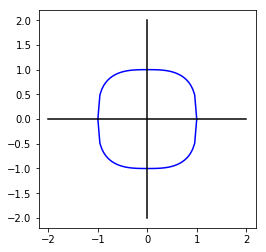

In [49]:
x_1 = np.linspace(-1,1)
f_1 = lambda x: 1 - x if x >= 0 else 1 + x
f_2 = lambda x: x - 1 if x >= 0 else - x - 1
g_1 = lambda x: (1-x**3)**(1.0/3) if x>0 else (1+x**3)**(1.0/3)
g_2 = lambda x: -(1-x**3)**(1.0/3) if x>0 else -(1+x**3)**(1.0/3)

plt.plot(x_1, np.vectorize(g_1)(x_1), color = 'blue')
plt.plot(x_1, np.vectorize(g_2)(x_1), color = 'blue')
plt.plot(2*x_1, 0 * x_1, 'black')
plt.plot(0*x_1, 2 * x_1, 'black')
plt.axes().set_aspect('equal')
plt.show()

This is a "smoother" circle. We now have the tools to go back and define more carefully what we mean by making coefficients smaller.

## Back to Regularization

So we can know set up a more formal optimization problem. You can view the idea of training a model as trying to solve this problem: $$ \min_\theta E(Y, f(X;\theta)) $$

which is exactly as described earlier- trying to find the global minimum (or something close) across all such $\theta$. Regularization simply takes this existing problem and applies a penalty for the size of the coefficients
$$\min_\theta E(Y, f(X;\theta)) \quad\text{subject to}\quad \Vert \theta \Vert_p \leq C $$

Any $p$ (or indeed any norm) would work here, but we are basically considering $p=1$ or $p=2$. This parameter $C$ must be chosen by us (through cross validation) and can be thought of as a budget. When $C$ is very high we have a lot of flexibility in the coefficients, so a more complicated model. Conversely when $C$ is low we have a simpler model.

We can also reframe this in the language of Lagrange multipliers too $$\min_\theta E(Y, f(X;\theta)) + \lambda \Vert \theta \Vert_p  $$

with $\lambda$ as our parameter (which is now an inverse budget).


# Difference between $L_1$ and $L_2$

So now we have a two ways we can apply a penalty to our coefficients and they look very similar. Both prevent any single coefficient getting too large, however there is a clear difference in how they behave with multiple parameters.

The $L_1$ penalty produces sparse models i.e. models where many of the coefficients are 0, whereas the $L_2$ penalty does not. In fact the $L_2$ model often shrinks coefficients so they are very small, but it is unlikely they ever disappear.

So why does this happen? Here is the image that shows why:

In [50]:
Image(url='https://qph.fs.quoracdn.net/main-qimg-583e319a860c9cc4a187e005fb4b7353')

So what is the picture showing? For $L_1$ the squareness of the unit circle means solutions to the constraint on coefficients are more likely to hit the corners, and hitting the corners is precisely when coefficients vanish. On the other hand in $L_2$, solutions can hit everywhere with equal probability, meaning it is very unlikely for coefficients to exactly vanish.

To understand the picture in a bit more detail, let's flesh out exactly what it is showing with an example. 

Let's consider two independent variables $x_1$ and $x_2$, and a training set $(1, 0) $ corresponding to a target value of $a$, and $(0,1)$ corresponding to a target value of $b$ where $a,b>0$. 

We will choose a linear model to map this, so our model family is $$f(x_1, x_2;\theta) = x_1\theta_1 + x_2\theta_2$$ where $\theta =(\theta_1, \theta_2)$ are our weights and for simplicity we are assuming no intercept term. For our error function we will choose mean squared error.

So now our prediction for our first training case is $f(1,0)=a$ and for our second $f(0,1)=b$. If we had no regularization constraint we could set $\theta_1=a$ and $\theta_2 =b$ and model this perfectly- but what happens when we impose a constraint?

With the $L_1$ penalty and a budget of 1 we will try and minimize $$\min_{\theta} (a-\theta_1)^2 + (b-\theta_2)^2 \quad \text{subject to} \quad \vert\theta_1\vert+\vert\theta_2\vert=1 $$

This is exactly what the above picture shows. We want to minimize the distance between the point $(a,b)$ and $(\theta_1, \theta_2)$ subject to $(\theta_1, \theta_2)$ lying inside the unit circle for the $L_1$ norm. The $L_2$ situation is the same, just with a different unit circle.

Now you can either draw a few pictures or solve some basic equations and you should see that with the $L_2$ unless $a=0$ or $b=0$ then $\theta_1 \neq 0 $ and $\theta_2 \neq 0$. So the only way for coefficient to vanish is if the training cases lie on an axis

However for the $L_1$ case, unless $ a+1>b>a-1$ a coefficient will vanish (it is worth trying to show this yourself). So basically there are large areas of the plane where only a sparse model will be found.

This is a toy example, but it illustrates the principle quite nicely, and the same thing happens for other models and more complicate training sets.

# What this means in practice?

This was a brief intro to what regularization means and how it works. As noted above the models we use in prod have regularization built in, and for our purposes we don't really need to consider the exact method. Both $L_1$ and $L_2$ regularization have some advantages and disadvantages, so there is no correct one to choose for all problems. In addition the elastic net (basically a combo of both $L_1$ and $L_2$ regularization) is a more flexible approach that allows you to get some benefits of both methods. 